In [20]:
# to ignore the warnings 
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# get the data from 

!wget https://www.dropbox.com/s/1nnj7xk0c46sxgg/BrainTumorData.zip?dl=0

# unzip the data
!unzip /content/BrainTumorData.zip?dl=0

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os 
import shutil
import math
import imutils
import cv2


In [3]:
# count the number of images in the respective classes 

ROOT_DIR = "/content/BrainTumorData/Brain Tumor Data Set"

num_of_images = {}

for dir in os.listdir(ROOT_DIR):
  num_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))

num_of_images

{'Brain Tumor': 2513, 'Healthey': 2087}

###we will split our data such that we have 
    * 70% for Train Data 
    * 15% for Validation 
    * 15% for Testing 

In [4]:
# we create a training folder 

if not os.path.exists("./train"):
  os.mkdir("./train")

  for dir in os.listdir(ROOT_DIR):
    os.makedirs("./train/"+dir)
    for img in np.random.choice(a=os.listdir(os.path.join(ROOT_DIR, dir) ) , 
                                size= (math.floor(70/100*num_of_images[dir])-5) , replace=False ):
      
      O = os.path.join(ROOT_DIR,dir,img)
      D = os.path.join('./train', dir)
      shutil.copy(O,D)
      os.remove(O)
else:
  print("Train Folder exsist")

In [5]:
# we create a Validation folder 

if not os.path.exists("./val"):
  os.mkdir("./val")

  for dir in os.listdir(ROOT_DIR):
    os.makedirs("./val/"+dir)
    for img in np.random.choice(a=os.listdir(os.path.join(ROOT_DIR, dir) ) , 
                                size= (math.floor(15/100*num_of_images[dir])-5) , replace=False ):
      
      O = os.path.join(ROOT_DIR,dir,img)
      D = os.path.join('./val', dir)
      shutil.copy(O,D)
      os.remove(O)
else:
  print("Train Folder exsist")

In [6]:
# we create a test folder 

if not os.path.exists("./test"):
  os.mkdir("./test")

  for dir in os.listdir(ROOT_DIR):
    os.makedirs("./test/"+dir)
    for img in np.random.choice(a=os.listdir(os.path.join(ROOT_DIR, dir) ) , 
                                size= (math.floor(15/100*num_of_images[dir])-5) , replace=False ):
      
      O = os.path.join(ROOT_DIR,dir,img)
      D = os.path.join('./test', dir)
      shutil.copy(O,D)
      os.remove(O)
else:
  print("Train Folder exsist")

### WE have now sucessfully devided our data 

## Lets now build our model 

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dense,Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization, MaxPooling2D, GlobalAvgPool2D
from keras.models import Sequential
from keras.preprocessing import image
import keras

In [8]:
# Cnn model 

model = Sequential() 
model.add(Conv2D(filters=16, kernel_size= (3,3), activation= 'relu', input_shape=(224,224,3)) )

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu' ))
model.add(MaxPool2D(pool_size=(2,2)))


model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu' ))
model.add(MaxPool2D(pool_size=(2,2)))


model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu' ))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(rate=0.25))

model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss= keras.losses.binary_crossentropy, optimizer='adam', metrics=['accuracy'] )
 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 32)      4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0

In [9]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']  )

## Preparing our data using data generator 

In [10]:
#train_datagen = image.ImageDataGenerator(preprocessing_function= , )

In [11]:
train_datagen = image.ImageDataGenerator(
     zoom_range = 0.2, shear_range = 0.2 , rescale = 1./255 , horizontal_flip=True
)

val_datagen = image.ImageDataGenerator(rescale = 1./255)

test_datagen = image.ImageDataGenerator(rescale = 1./255)

In [12]:
train_data = train_datagen.flow_from_directory(directory= "/content/train", target_size=(224,224), batch_size=32,
                                  class_mode = 'binary', 
                                  )



Found 3209 images belonging to 2 classes.


In [13]:
train_data.class_indices

{'Brain Tumor': 0, 'Healthey': 1}

In [14]:
val_data = val_datagen.flow_from_directory(directory= "/content/val", target_size=(224,224), batch_size=32,
                                  class_mode = 'binary'
                                  )

Found 679 images belonging to 2 classes.


In [15]:
test_data = test_datagen.flow_from_directory(directory= "/content/test", target_size=(224,224), batch_size=32,
                                  class_mode = 'binary'
                                  )

Found 679 images belonging to 2 classes.


In [16]:
## having early stopping and model check point 

from keras.callbacks import ModelCheckpoint, EarlyStopping

# early stopping
es = EarlyStopping(monitor='val_accuracy', min_delta= 0.01 , patience= 5, verbose= 1, mode='auto')

# model check point
mc = ModelCheckpoint(filepath="best_model.h5", monitor= 'val_accuracy', verbose= 1, save_best_only= True, mode = 'auto')

# puting call back in a list 
call_back = [es, mc]

In [17]:
hist = model.fit_generator(generator=train_data , 
                              steps_per_epoch= 8 , 
                              epochs= 30 , verbose= 1, 
                              validation_data= val_data , 
                              validation_steps= 16,
                              callbacks = call_back )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
8/8 [==============================] - 37s 712ms/step - loss: 0.7048 - accuracy: 0.5431 - val_loss: 0.6223 - val_accuracy: 0.6699

Epoch 00001: val_accuracy improved from -inf to 0.66992, saving model to best_model.h5
Epoch 2/30
8/8 [==============================] - 5s 686ms/step - loss: 0.6555 - accuracy: 0.5859 - val_loss: 0.6134 - val_accuracy: 0.6875

Epoch 00002: val_accuracy improved from 0.66992 to 0.68750, saving model to best_model.h5
Epoch 3/30
8/8 [==============================] - 5s 705ms/step - loss: 0.6514 - accuracy: 0.6257 - val_loss: 0.6117 - val_accuracy: 0.7305

Epoch 00003: val_accuracy improved from 0.68750 to 0.73047, saving model to best_model.h5
Epoch 4/30
8/8 [==============================] - 5s 688ms/step - loss: 0.6763 - accuracy: 0.5931 - val_loss: 0.6035 - val_accuracy: 0.7051

Epoch 00004: val_accuracy did not improve from 0.73047
Epoch 5/30
8/8 [==============================] - 5s 682ms/step - loss: 0.6200 - accuracy: 0.6741 - val_loss: 0.5

In [18]:
# Loading the best fit model 
from keras.models import load_model

model = load_model("/content/best_model.h5")

# Model Accuracy

In [21]:


# checking out the accuracy of our model 

acc = model.evaluate_generator(generator= test_data)[1] 

print(f"The accuracy of your model is = {acc*100} %")

The accuracy of your model is = 80.70692420005798 %


In [ ]:
h =  hist.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

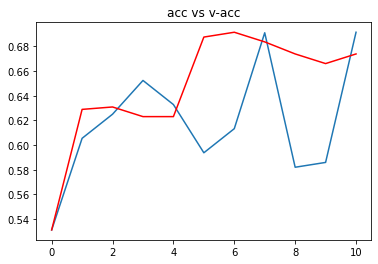

In [ ]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'] , c = "red")
plt.title("acc vs v-acc")
plt.show()

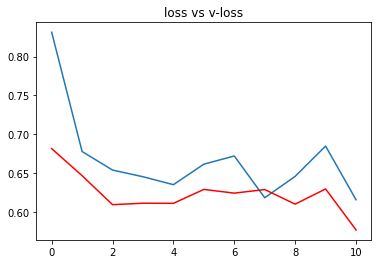

In [ ]:
plt.plot(h['loss'])
plt.plot(h['val_loss'] , c = "red")
plt.title("loss vs v-loss")
plt.show()

In [ ]:
# path for the image to see if it predics correct class

path = "/content/val/Healthey/Not Cancer  (1768).jpg"
img = image.load_img(path, target_size=(224,224),  )

i = image.img_to_array(img)/255
input_arr = np.array([i])
input_arr.shape

pred = model.predict_classes(input_arr)[0][0] 



if pred == 0:
  print("The MRI image is of BRAIN TUMOR")
else:
  print("The MRI image is of Healthey brain")

The MRI image is of Healthey brain
